# Avaliação em holdouts - Amazon Kindle

* Exp1: 10 last examples of each user 
* Exp7: 10 last examples, and dont remove items that are in holdout from train data, and allow seen items, and dont remove items sent to holdout from bucket


# Import stuff

In [3]:
import os
import sys
sys.path.append(os.path.abspath('') + '/../..')

In [4]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [5]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
# Read Data

In [7]:
# importa dataset 'palco playlists'
data = pd.read_csv('../output/amazonkindle_dump/2nd_sampled_amazon_kindle.csv')
dataset_name = 'Amazon_Kindle'
user_col = 'user_id'
item_col = 'item_id'

In [10]:
data.shape, data[user_col].nunique(), data[item_col].nunique()

((77145, 4), 13902, 59197)

In [11]:
data[[user_col, item_col]].duplicated().sum()

363

In [13]:
data.head()

,user_id,item_id,timestamp,date
0,B000FA5PV4,A23NR7891PY2P1,1388534400,2014-01-01
1,B000FC1LLA,A1CBHVD1PG6UUV,1388534400,2014-01-01
2,B000GFK7L6,ARISSM47DJHQ8,1388534400,2014-01-01
3,B000QCS8YM,A1SBCP7BB2QK9T,1388534400,2014-01-01
4,B000VDUWMC,ABSBO832VAJ36,1388534400,2014-01-01


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77145 entries, 0 to 77144
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    77145 non-null  object
 1   item_id    77145 non-null  object
 2   timestamp  77145 non-null  int64 
 3   date       77145 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.4+ MB


### Convert timestamp

In [15]:
%%time 
# 2.42s
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
# data.sort_values(by='timestamp', inplace=True)

CPU times: user 526 ms, sys: 2.67 ms, total: 528 ms
Wall time: 526 ms


CPU times: user 71.5 ms, sys: 800 µs, total: 72.3 ms
Wall time: 69.4 ms


Text(0.5, 1.0, 'interactions per month')

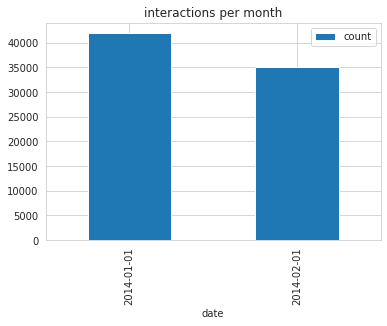

In [18]:
%%time
# 198ms
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.date
_.groupby('date').sum().plot(kind='bar')
plt.title('interactions per month')

# Hyperparameters

In [19]:
# define hyperparameters
num_factors = 100
num_iter = 8
learn_rate = 0.5
regularization = 0.3
num_nodes = 4

# EXPERIMENT 1

CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT  
IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT  
INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETSLAST 10 INTERACTIONS FROM EACH USER AS HOLDOUT  

In [20]:
# CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT
# IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT
# INTERACTIONS IN HOLDOUT ARE REMOVED FROM ALL BUCKETS

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

Creating buckets. . .


In [21]:
# get frequent users - threshold = N
all_users = data[user_col].unique()
frequent_users_per_bucket = []
for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        condition = (b[user_col].value_counts() > N)
        frequent_users_per_bucket.append(list(b[user_col].value_counts()[ condition ].index))
frequent_users = []
for u in all_users:
    check_u = [u in fulist for fulist in frequent_users_per_bucket]
    if np.all( check_u ):
        frequent_users.append(u)

In [22]:
#CHANGE FREQUENT USERS BELOW!

In [23]:
print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []

for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        condition = (b[user_col].value_counts() > N)
        frequent_users = b[user_col].value_counts()[ condition ].index
        holdout_idx = []
        for u in frequent_users:
            tail_idx = list( b[b[user_col] == u].tail(N).index )
            holdout_idx += tail_idx
        holdout = b.loc[holdout_idx].reset_index(drop=True)
        holdouts.append(holdout)
        buckets[i] = b.drop(index=holdout_idx).reset_index(drop=True)

print('Removing seen examples from buckets')

for i, h in enumerate( holdouts ):
    h_ = h[[user_col, item_col]]
    for idx, example in h_.iterrows():
        for j in range( len(buckets) ): # using range instead of enumerate bc we have to modify the buckets
            b = buckets[j]
            b_ = b[[user_col, item_col]]
            examples_seen = np.where( (b_ == example).all(axis=1) )[0]
            # For now, we are going to drop these examples
            # print(i, j, b.shape)
            b.drop(index=examples_seen, inplace=True)
            b.reset_index(drop=True, inplace=True)
            buckets[j] = b


Creating holdouts. . .
Removing seen examples from buckets


In [24]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [25]:
sum( [b.size for b in buckets] ), sum( [h.size for h in holdouts] )

(65327, 11810)

In [26]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [27]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [28]:
%%time
# 28min 20s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 1830
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
CPU times: user 2h 41min 40s, sys: 7h 1min 27s, total: 9h 43min 8s
Wall time: 49min 16s


In [29]:
rm = eval.results_matrix
df_exp1 = pd.DataFrame(rm)
# df.to_csv('output/palco_2010_dump/sample_palco2010 month_bucket ISGD results.csv', index=False)

# Result EXP 1

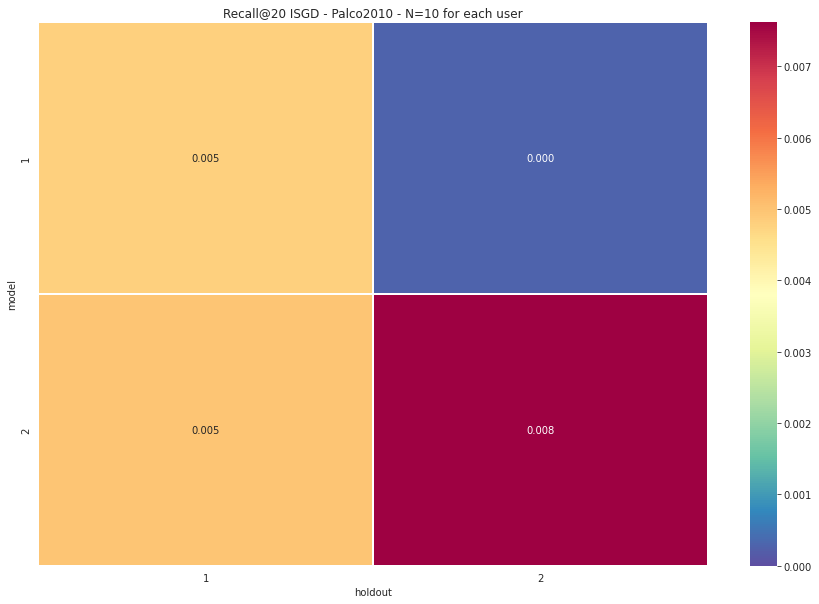

In [30]:
# result with N=10 last interactions of each user - items in holdout are removed from the training data
recall_heatmap(df_exp1,
    round_point=3,
    title='Recall@20 ISGD - Palco2010 - N=10 for each user',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [31]:
arecall = avg_recall(df_exp1)
arecall

0.006220984349615823

In [32]:
BWT, meanBWT = compute_BWT(df_exp1)
BWT, meanBWT

([0.00015552099533436975], 0.00015552099533436975)

In [33]:
FWT = compute_FWT(df_exp1)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.00028169014084507044

# EXPERIMENT 7

CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT  
* IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT  
* LAST 10 INTERACTIONS FROM EACH USER AS HOLDOUT
* RECOMENDING SEEN ITEMS IS ALLOWED
* DON'T REMOVE INTERACTIONS IN HOLDOUT FROM BUCKETS
* DON'T REMOVE INTERACTIONS **SENT** TO HOLDOUT FROM BUCKET

In [34]:
# CODE TO GET LAST N INTERACTIONS FROM EACH USER AS HOLDOUT
# IF USER DID NOT INTERACT WITH AT LEAST N+1 ITEMS, THEN IT IS NOT USED FOR HOLDOUT

N = 10
cold_start_buckets = 0
#     print('0',data.shape[0]) # debug
print('Creating buckets. . .')
buckets = []
# assert interval_type in ['W', 'M', 'QS', 'F'], "interval must be one of W, M, QS, or F"
# create buckets based on months
months = data['date'].unique()
for interval in months:
    idx = (data['date'] == interval)
    buckets.append( data[idx] )

print('Creating holdouts. . .')
# create holdouts with last user interaction
holdouts = []

for i, b in enumerate( buckets ):
    if i >= cold_start_buckets:
        condition = (b[user_col].value_counts() > N)
        frequent_users = b[user_col].value_counts()[ condition ].index
        holdout_idx = []
        for u in frequent_users:
            tail_idx = list( b[b[user_col] == u].tail(N).index )
            holdout_idx += tail_idx
        holdout = b.loc[holdout_idx].reset_index(drop=True)
        holdouts.append(holdout)
        # buckets[i] = b.drop(index=holdout_idx).reset_index(drop=True)
        buckets[i] = b.reset_index(drop=True)

Creating buckets. . .
Creating holdouts. . .


In [35]:
print('Converting to ImplicitData. . .')
for i, b in enumerate(buckets):
    buckets[i] = ImplicitData(user_list=b[user_col], item_list=b[item_col]) # convert to ImplicitData

for j, h in enumerate(holdouts):
    holdouts[j] = ImplicitData(user_list=h[user_col], item_list=h[item_col]) # convert to ImplicitData

print('Done!')
# return buckets, holdouts

Converting to ImplicitData. . .
Done!


In [36]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

88955

In [40]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [41]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [1]:
%%time
# other experiments used 20 recommendations
eval.Train_Evaluate(N_recommendations=10, exclude_known_items=False, default_user='none')

AttributeError: 'builtin_function_or_method' object has no attribute 'Train_Evaluate'

In [43]:
rm = eval.results_matrix
df_exp7 = pd.DataFrame(rm)
# df.to_csv('output/palco_2010_dump/sample_palco2010 month_bucket ISGD results.csv', index=False)

# Result EXP 7

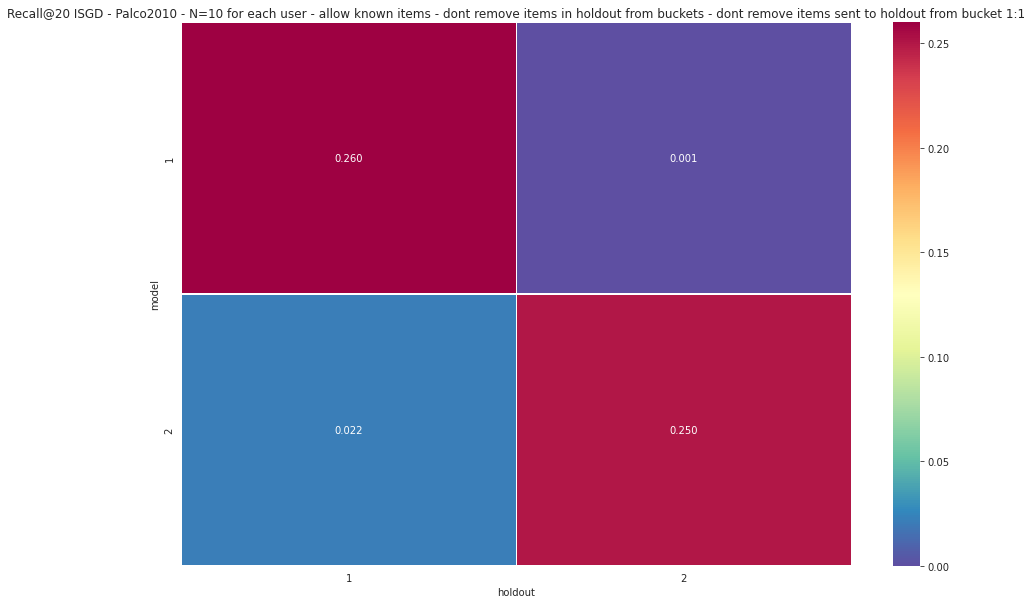

In [44]:
# result with N=10 last interactions of each user - items in holdout are removed from the training data
recall_heatmap(df_exp7,
    round_point=3,
    title='Recall@20 ISGD - Palco2010 - N=10 for each user - allow known items - dont remove items in holdout from buckets - dont remove items sent to holdout from bucket 1:1',
    filepath=None) #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [45]:
arecall = avg_recall(df_exp7)
arecall

0.2552791862031486

In [46]:
BWT, meanBWT = compute_BWT(df_exp7)
BWT, meanBWT

([-0.23794712286158629], -0.23794712286158629)

In [47]:
FWT = compute_FWT(df_exp7)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0005633802816901409

# Store exp results

In [48]:
# allresults = [df_exp1, df_e1xp2, df_exp3, df_exp4, df_exp5, df_exp6, df_exp7, df_exp8, df_exp9]
allresults = [df_exp1,df_exp7]

In [50]:
for r in range( len(allresults )):
    allresults[r].to_csv(f'../output_p10_10_examples/Kindle_ISGD_result_exp_{r+1}')

# Read results

In [2]:
import os
import sys
sys.path.append(os.path.abspath('') + '/../..')
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

* Exp1: 10 last examples of each user 
* Exp3: 10 last examples, and allow seen items
* Exp5: 10 last examples, and dont remove items that are in holdout from train data, and allow seen items
* Exp7: 10 last examples, and dont remove items that are in holdout from train data, and allow seen items, and dont remove items sent to holdout from bucket
* Exp9: 10 randomly selected examples from each user, and dont remove items that are in holdout from train data, and allow seen items, and dont remove items sent to holdout from bucket

In [3]:
results_10_each_user = {}
for r in range( 2 ):
    results_10_each_user[r+1]=pd.read_csv(f'../output_p10_10_examples/Kindle_ISGD_result_exp_{r+1}', index_col=0)

results_10_each_user = {
    k: {
        'avg_recall': avg_recall( results_10_each_user[k]),
        'BWT': compute_BWT( results_10_each_user[k] )[-1],
        'FWT': compute_FWT( results_10_each_user[k] )
        }
    for k in results_10_each_user.keys()
}

results_10_each_user = pd.DataFrame( results_10_each_user )

results_10_each_user.columns = [1, 7]
results_10_each_user

,1,7
avg_recall,0.006221,0.255279
BWT,0.000156,-0.237947
FWT,0.000282,0.000563


# ORIGINAL RESULT - DONT CONTINUE

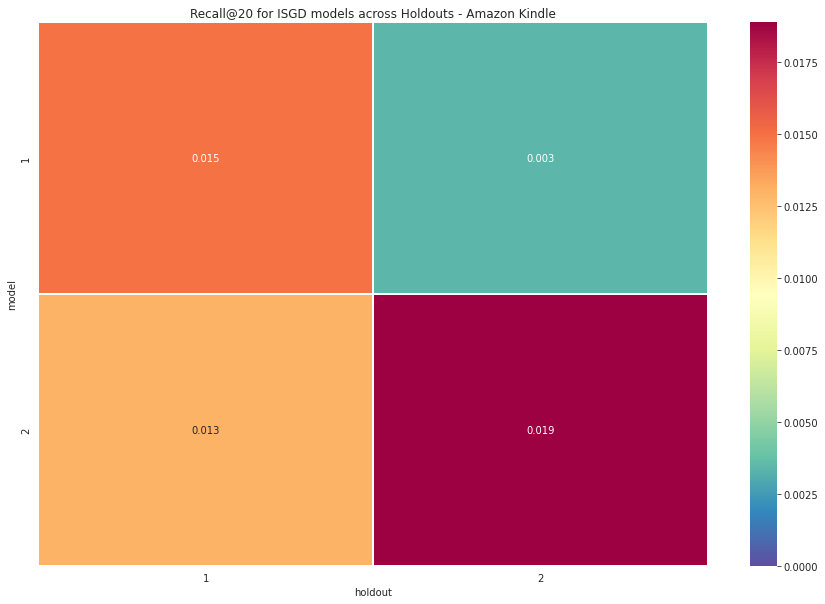

In [ ]:
# #0.0 freq T
# recall_heatmap(df,
#                round_point=3,
#                title='Recall@20 for ISGD models across Holdouts - Amazon Kindle',
#                filepath='images/heatmaps/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [ ]:
arecall = avg_recall(df)
arecall

0.016909808048269935

In [ ]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-0.0019258545979778524], -0.0019258545979778524)

In [ ]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.003431933322438307